In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
import dateutil.parser
import statsmodels.api as sm
from datetime import date
from datetime import datetime
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [3]:
aapl = yf.Ticker("SPY")
aapl?

Type:        Ticker
String form: yfinance.Ticker object <SPY>
File:        ~/anaconda3/lib/python3.11/site-packages/yfinance/ticker.py
Docstring:   <no docstring>

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

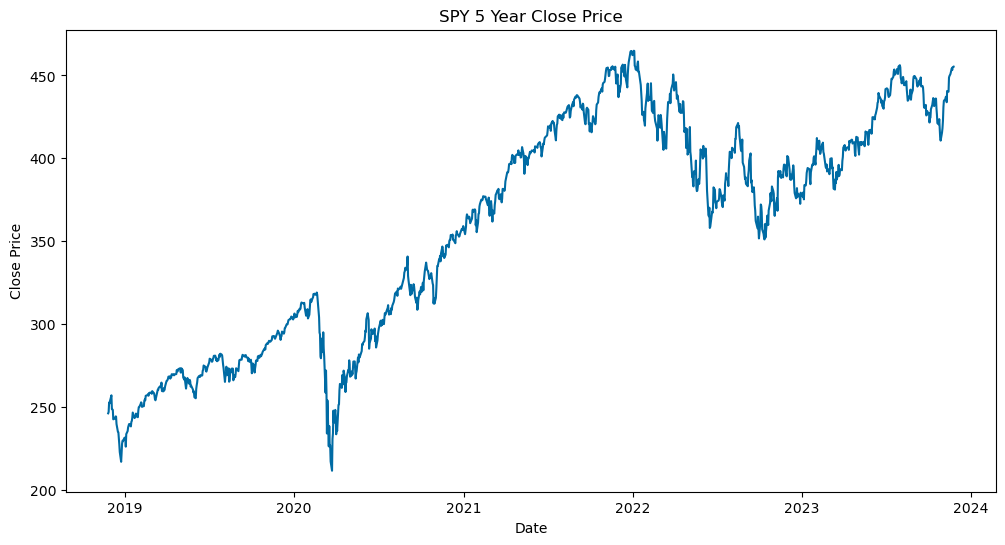

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY 5 Year Close Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [5]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=301.400846, mean2=415.338846, mean_percent_diff=37.802814
variance1=2070.382328, variance2=684.055082, var_percent_diff=-66.959963


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [6]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.345157
p-value: 0.608268
Critical Values:
{'1%': -3.4356006420838963, '5%': -2.8638586845641063, '10%': -2.5680044958343604}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [7]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.700066781466412, 0.01, 21, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.70
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/4j/vvgx0bbx7313m1cgfdrp_4b00000gn/T/ipykernel_8425/2395884048.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(X)


##### P-value < .05; therefore, not stationary

### Transform into stationary series

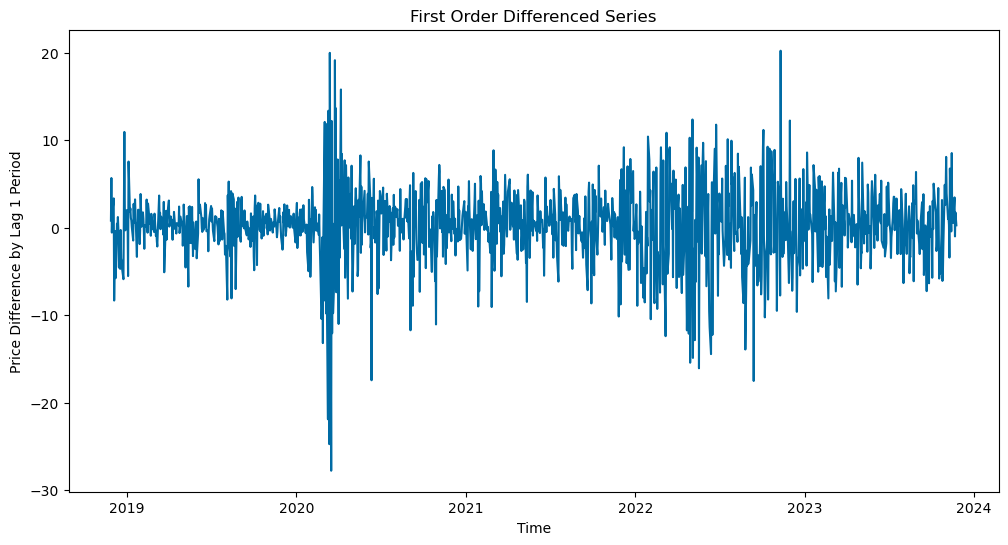

In [8]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14) 
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [9]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -10.789071
p-value: 0.000000
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [10]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [11]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [12]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [13]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

Time Series Evaluation Metrics
MSE = 1115.5927101041343
MAE = 27.162460331518467
RMSE = 33.400489668628126
MAPE = 0.06285612504406843
r2 = -1.1348071233405137



/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


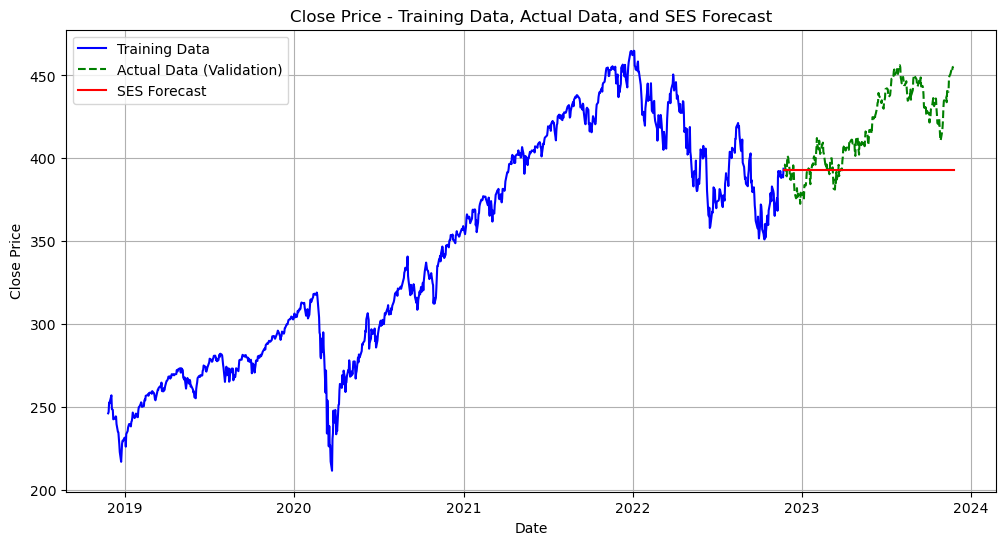

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#### WORKING IN PROGRESS to be investigate ######

# #impute
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

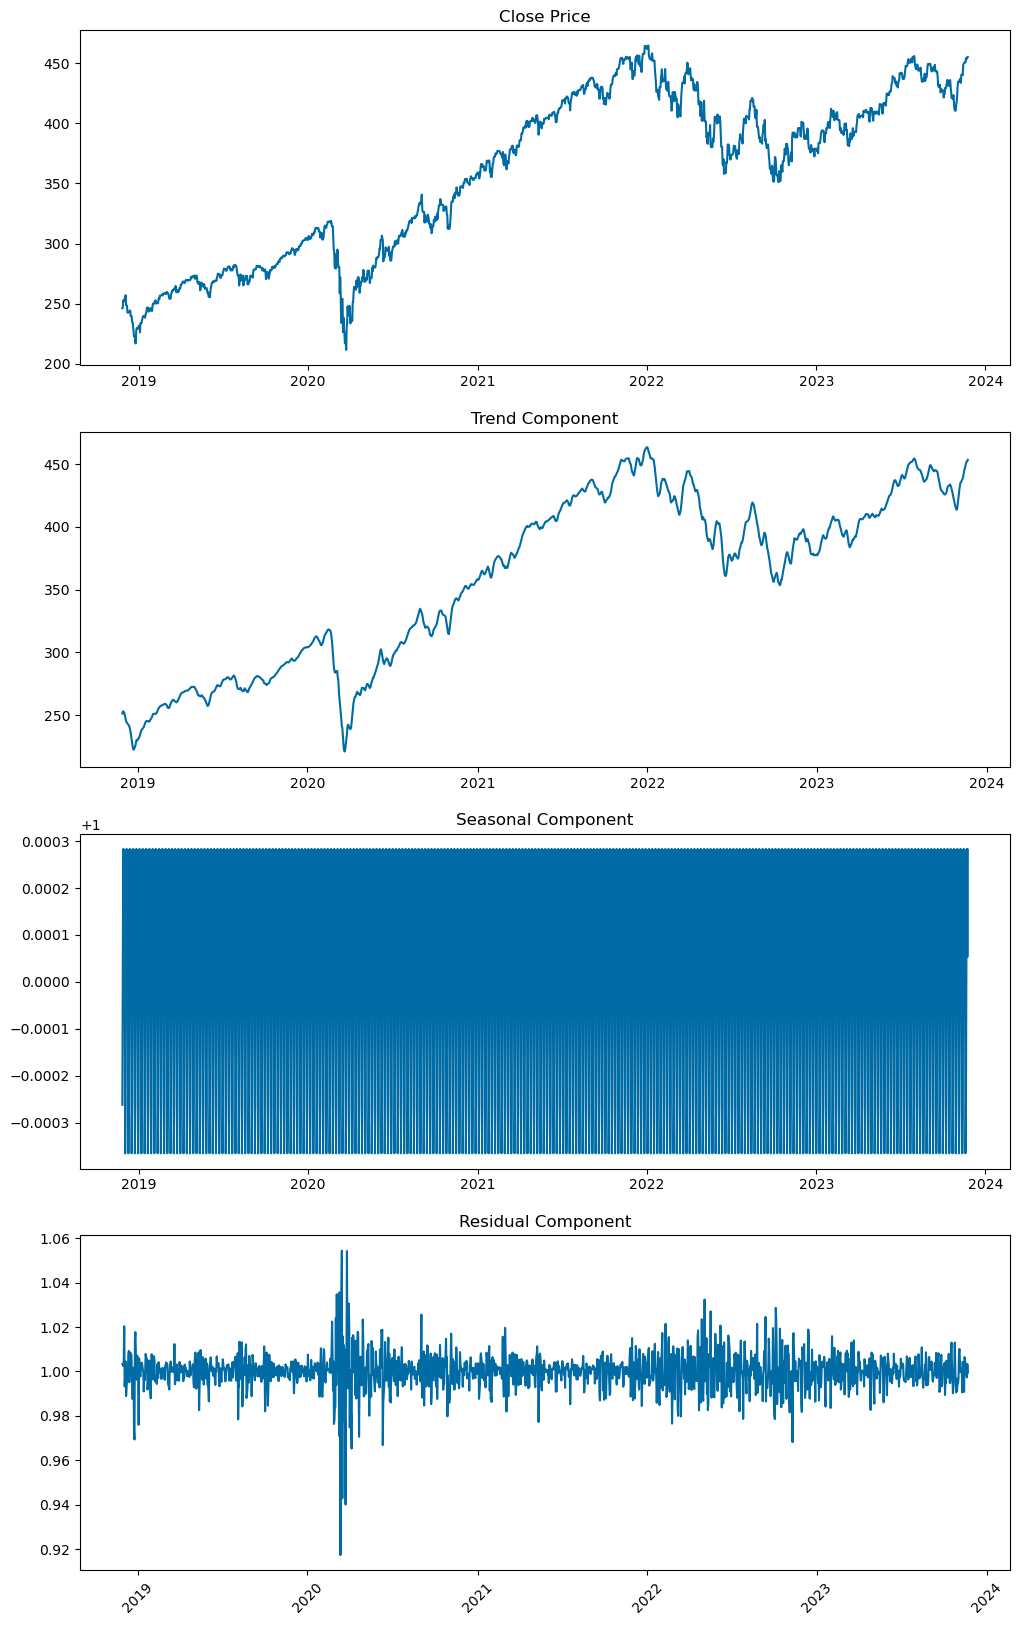

In [16]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

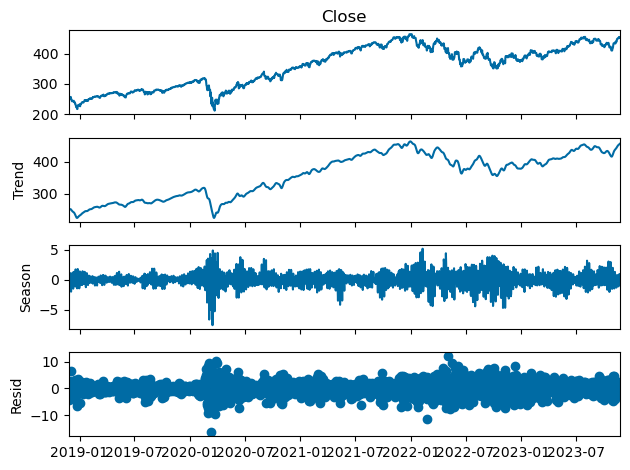

In [17]:
stl = STL(close).fit().plot()


### Autocorrelation - Raw Values

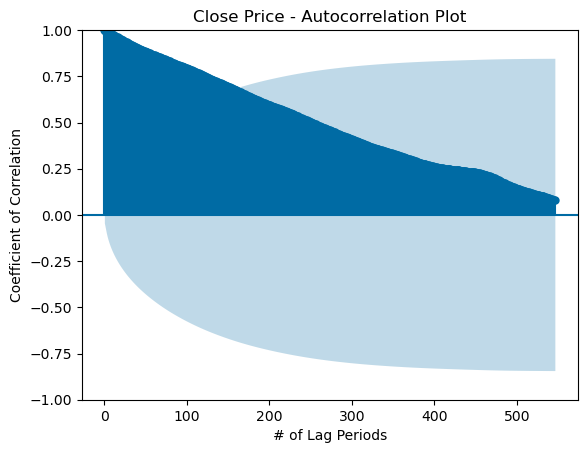

In [18]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

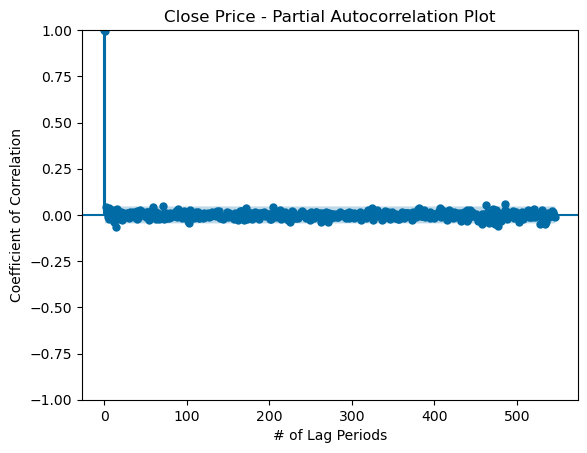

In [19]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

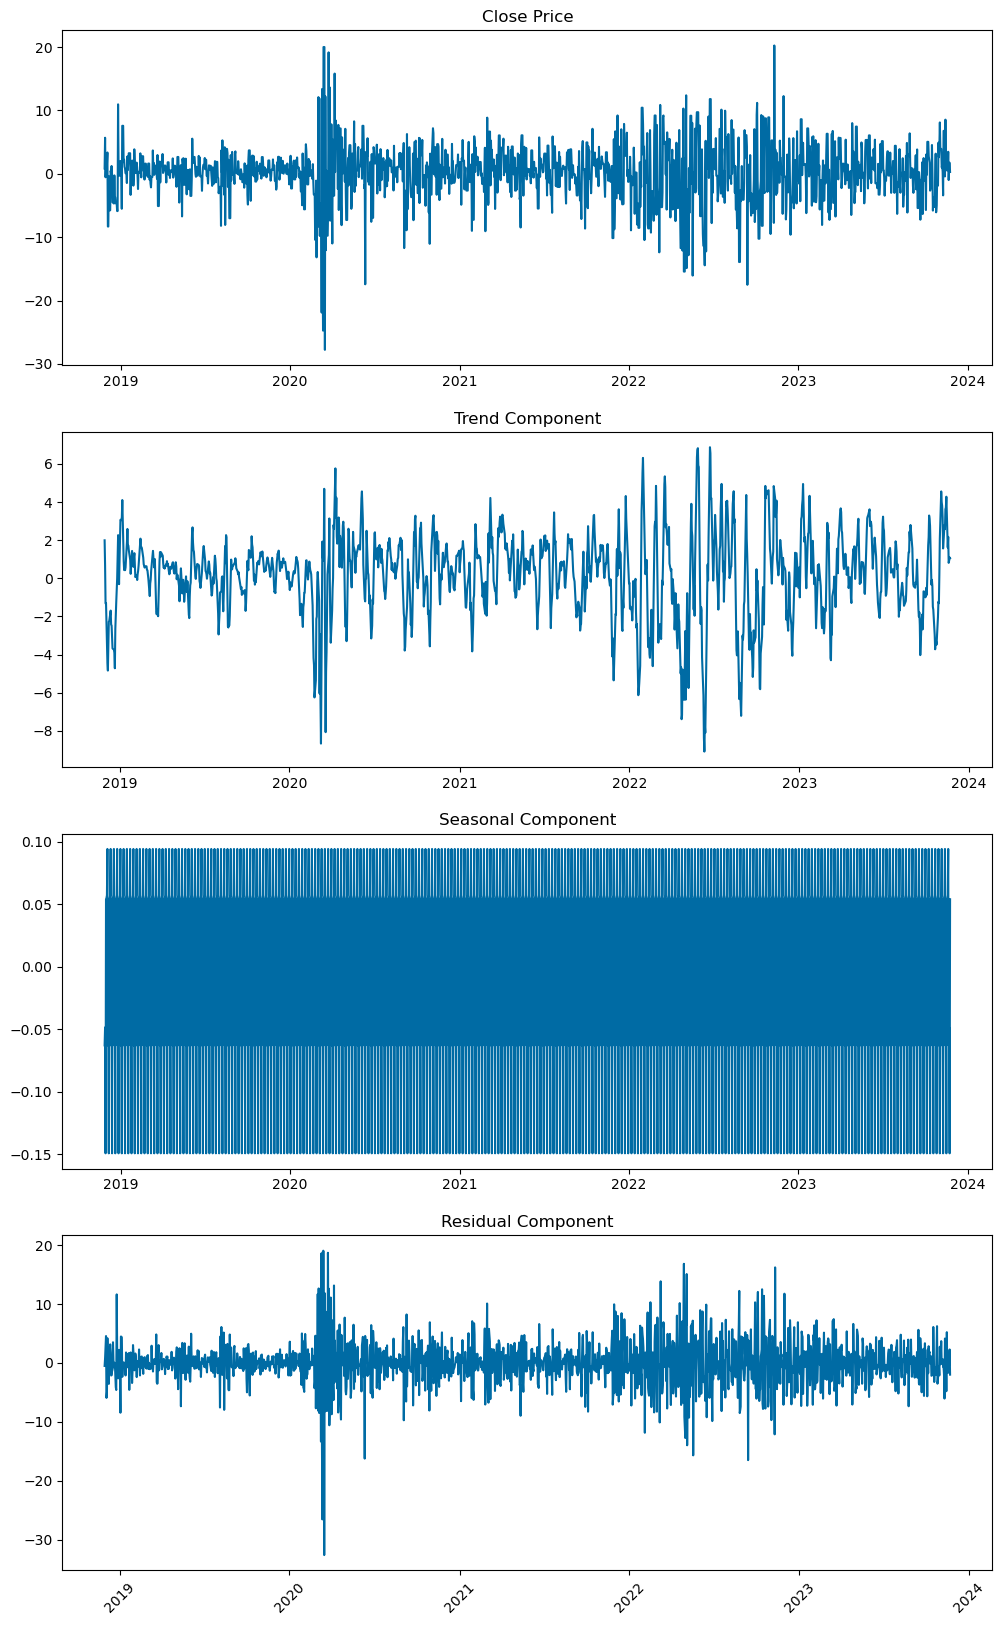

In [20]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

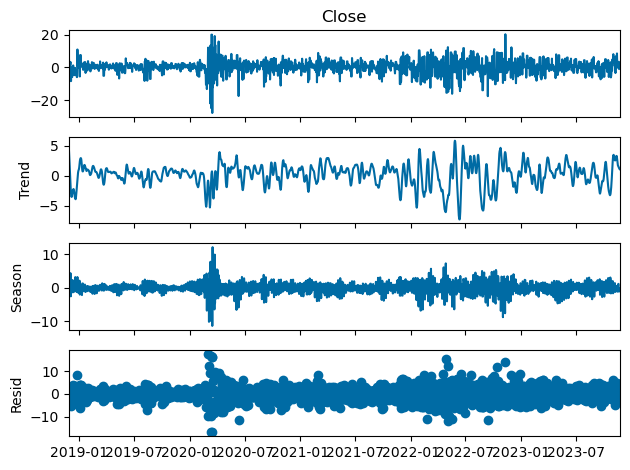

In [21]:
stl = STL(ts_lag_1).fit().plot()

# ARIMA Parameter Selection
##### Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29

### ACF on lag_1 period

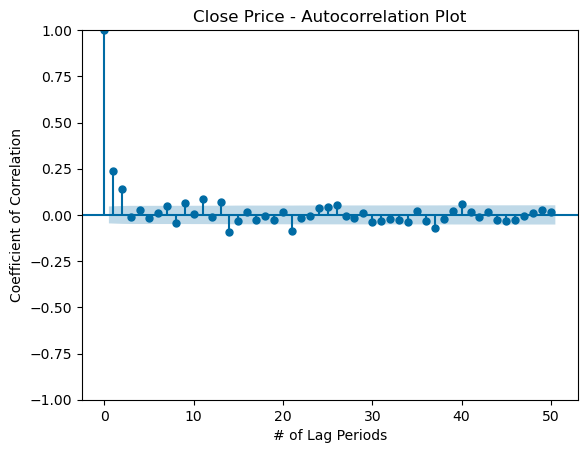

In [22]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Therefore, based on ACF plot, we may want to do MA at 0, 1, 2, 11, 13, 14, 21, 37, 40.

### Plot PACF on lag_1 period

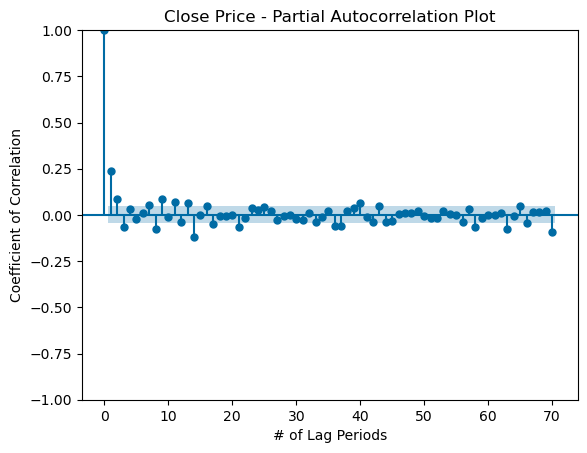

In [23]:
plot_pacf(ts_lag_1, lags=70)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR at 1, 2, 3, 8, 9, 11, 14, and 21, 58, 63, 70.

In [24]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]#, 58, 63]#, 70] # based on PACF
#ar_orders = [58, 63]#, 70] # based on PACF # attempting higher order from PACF
ma_orders = [1, 2, 11, 13, 14, 21] # based on ACF
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(ar_order,1,1),trend='n') #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC for AR(1): 10447.92224983472
BIC for AR(1): 10464.446966158757


AIC for AR(2): 10436.18863858729
BIC for AR(2): 10458.221593686005


AIC for AR(3): 10430.962840187249
BIC for AR(3): 10458.504034060643


AIC for AR(8): 10423.025074645422
BIC for AR(8): 10478.107462392209


AIC for AR(9): 10411.260046378022
BIC for AR(9): 10471.850672899487


AIC for AR(11): 10406.254518658248
BIC for AR(11): 10477.861622729071


AIC for AR(14): 10375.402168783865
BIC for AR(14): 10463.533989178724


AIC for AR(21): 10372.972685653327
BIC for AR(21): 10499.662177470937




### Select AR(14) due to lowest AIC and BIC

### Rerun with AR(14) as default and iterate through different MA orders based on ACF

In [25]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

#ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]
ar_orders = [0, 1, 2, 11, 13, 14, 21, 37, 40] #actually MA orders, but using same var name for simplicity
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,ar_order)) #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/johnvincent/anaconda3/li

AIC for MA(0): 10480.597564448304
BIC for MA(0): 10563.221146068485


AIC for MA(1): 10375.402168783865
BIC for MA(1): 10463.533989178724


AIC for MA(2): 10405.219286679534
BIC for MA(2): 10498.85934584907


AIC for MA(11): 10367.654378488418
BIC for MA(11): 10510.868586630064


AIC for MA(13): 10361.533288020892
BIC for MA(13): 10515.763973711893


AIC for MA(14): 10366.411040422845
BIC for MA(14): 10526.149964888526


AIC for MA(21): 10369.851183924064
BIC for MA(21): 10568.147779812496


AIC for MA(37): 10359.273061719463
BIC for MA(37): 10645.701478002753


AIC for MA(40): 10362.309400033566
BIC for MA(40): 10665.262532640892




### AIC and BIC minimization suggest order=(14,1,1) is the optimal 3-tuple

### Measure error statistics on validation set

In [26]:
arima_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,1)).fit() #import statsmodels.api as sm for ARIMA

arima_pred = arima_model.forecast(steps=len(close_valid))
arima_metrics = ts_eval_metrics(close_valid, arima_pred)

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Time Series Evaluation Metrics
MSE = 174709.65940663544
MAE = 417.35753852488773
RMSE = 417.9828458281936
MAPE = 0.9995166272401114
r2 = -333.325800123654



### Interpretation: Even with minimum AIC and BIC, ARIMA optimal pdq based on ACF and PACF performs very poorly

## Attempt: Find optimal AES model parameters

In [27]:
#close_train = pd.DataFrame(close_train)
#close_train.reset_index(inplace=True)

In [28]:
#close_train.index

In [29]:
# Reference: https://www.statsmodels.org/stable/generated/
# statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing

aes_param_trend = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_damped_trend = [True, False]
aes_param_seasonal = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_seasonal_periods = [2, 3, 8, 9, 11, 14, 21, 58, 59, 60, 61, 62, 63, 64, 65, 70] # Informed by PACF
aes_param_initial_method = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied = [True, False]
fit_method = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict = {}

### Searching for ideal seasonal period parameter

In [30]:
for i in aes_param_seasonal_periods:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= i, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

Results for Seasonal Period 2
AIC = 3549.793923657795
BIC = 3584.190085112413
Time Series Evaluation Metrics
MSE = 1244.3225940370821
MAE = 28.930221549390136
RMSE = 35.274957038061466
MAPE = 0.06695249596264187
r2 = -1.3811456577516985

Results for Seasonal Period 3
AIC = 3860.430665457299
BIC = 3899.7405642625763
Time Series Evaluation Metrics
MSE = 1199.0961804669505
MAE = 28.284200306714393
RMSE = 34.627968182770275
MAPE = 0.0654459582983675
r2 = -1.294600031397033

Results for Seasonal Period 8
AIC = 4433.196542225955
BIC = 4497.075127784531
Time Series Evaluation Metrics
MSE = 1843.4944167021658
MAE = 40.41497533654359
RMSE = 42.935933863166014
MAPE = 0.09707602492415883
r2 = -2.5277256448250647

Results for Seasonal Period 9
AIC = 4450.24459554308
BIC = 4519.036918452316
Time Series Evaluation Metrics
MSE = 3365.8839029198507
MAE = 54.842810739133796
RMSE = 58.01623826929708
MAPE = 0.13109721635183383
r2 = -5.440982329133129

Results for Seasonal Period 11
AIC = 4365.87640540334

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

### Seasonal Periods at 2, 3, and 60 appear to be locally optimal candidate parameter values, but accounting for AIC and BIC, Seasonal Period 2 or 3 may be ideal.

### Searching for ideal seasonal parameter

In [31]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_seasonal:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= i, # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal add
AIC = 3898.0247343927867
BIC = 3932.4208958474046
Time Series Evaluation Metrics
MSE = 714.3378593422473
MAE = 21.693838899485847
RMSE = 26.72709971811845
MAPE = 0.051907661970169654
r2 = -0.3669626350043964

Results for Seasonal mul
AIC = 3895.7169460264945
BIC = 3930.1131074811124
Time Series Evaluation Metrics
MSE = 849.3428755564577
MAE = 23.968940558461355
RMSE = 29.143487704055904
MAPE = 0.057224152901755816
r2 = -0.6253093126856222

Results for Seasonal additive
AIC = 3898.0247343927867
BIC = 3932.4208958474046
Time Series Evaluation Metrics
MSE = 714.3378593422473
MAE = 21.693838899485847
RMSE = 26.72709971811845
MAPE = 0.051907661970169654
r2 = -0.3669626350043964

Results for Seasonal multiplicative
AIC = 3895.7169460264945
BIC = 3930.1131074811124
Time Series Evaluation Metrics
MSE = 849.3428755564577
MAE = 23.968940558461355
RMSE = 29.143487704055904
MAPE = 0.057224152901755816
r2 = -0.6253093126856222

Results for Seasonal None
AIC = 4639.411450051

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

### Validation statistics suggest additive seasonality is optimal

### Searching for ideal trend parameter

In [32]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend=i, # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Trend %s' % (i))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

Results for Trend add
AIC = 3860.3662190595414
BIC = 3899.676117864819
Time Series Evaluation Metrics
MSE = 1218.3389155897025
MAE = 28.548621885935134
RMSE = 34.904711939646525
MAPE = 0.06606048001772151
r2 = -1.3314230830722016

Results for Trend mul
AIC = 3907.5312008137703
BIC = 3946.841099619048
Time Series Evaluation Metrics
MSE = 175.45360305652312
MAE = 11.179369407386252
RMSE = 13.245890043954129
MAPE = 0.026827851065764845
r2 = 0.6642505833640115

Results for Trend additive
AIC = 3860.3662190595414
BIC = 3899.676117864819
Time Series Evaluation Metrics
MSE = 1218.3389155897025
MAE = 28.548621885935134
RMSE = 34.904711939646525
MAPE = 0.06606048001772151
r2 = -1.3314230830722016

Results for Trend multiplicative
AIC = 3907.5312008137703
BIC = 3946.841099619048
Time Series Evaluation Metrics
MSE = 175.45360305652312
MAE = 11.179369407386252
RMSE = 13.245890043954129
MAPE = 0.026827851065764845
r2 = 0.6642505833640115



ValueError: Can only dampen the trend component

### Validation statistics suggest multiplicative trend is optimal

### Searching for ideal aes_param_damped_trend parameter

In [34]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_damped_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=i, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Damped Trend %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Damped Trend True
AIC = 3893.176232510902
BIC = 3932.4861313161796
Time Series Evaluation Metrics
MSE = 200.75579996767917
MAE = 11.861278794885399
RMSE = 14.168831990241086
MAPE = 0.02890341259788917
r2 = 0.6158320971970859

Results for Damped Trend False
AIC = 3898.024275221114
BIC = 3932.4204366757317
Time Series Evaluation Metrics
MSE = 714.3411295310433
MAE = 21.693898605866423
RMSE = 26.727160895445728
MAPE = 0.05190780248240644
r2 = -0.3669688928638044



### Validation statistics suggest trend should be damped.

### Searching for optimal initialization method

In [35]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_initial_method:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method=i
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Initialization Method None
AIC = 3908.4758024564294
BIC = 3942.8719639110473
Time Series Evaluation Metrics
MSE = 351.3307929464094
MAE = 15.036743315178569
RMSE = 18.743820126815383
MAPE = 0.03631701797594984
r2 = 0.32769058757935476

Results for Initialization Method estimated
AIC = 3897.0963587810043
BIC = 3931.492520235622
Time Series Evaluation Metrics
MSE = 374.2791408597166
MAE = 15.549527240803007
RMSE = 19.346295274799168
MAPE = 0.03753397061907455
r2 = 0.28377644566133187

Results for Initialization Method heuristic
AIC = 3901.338800486365
BIC = 3935.734961940983
Time Series Evaluation Metrics
MSE = 379.70633414844394
MAE = 15.667708752777818
RMSE = 19.486054863631168
MAPE = 0.03781430204721284
r2 = 0.27339092522221087

Results for Initialization Method legacy-heuristic
AIC = 3908.4758024564294
BIC = 3942.8719639110473
Time Series Evaluation Metrics
MSE = 351.3307929464094
MAE = 15.036743315178569
RMSE = 18.743820126815383
MAPE = 0.03631701797594984
r2 = 0.3276905

### Validation statistics suggest initialization should be heuristic.

### Final pre-fit Advanced Exponential Smoothing Model w/ Parameters

In [36]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 3, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3888.8385851884805
BIC = 3928.148483993758
Time Series Evaluation Metrics
MSE = 248.03856579946
MAE = 13.115059331512233
RMSE = 15.749240165781332
MAPE = 0.031130653402745057
r2 = 0.5253514187248277

None


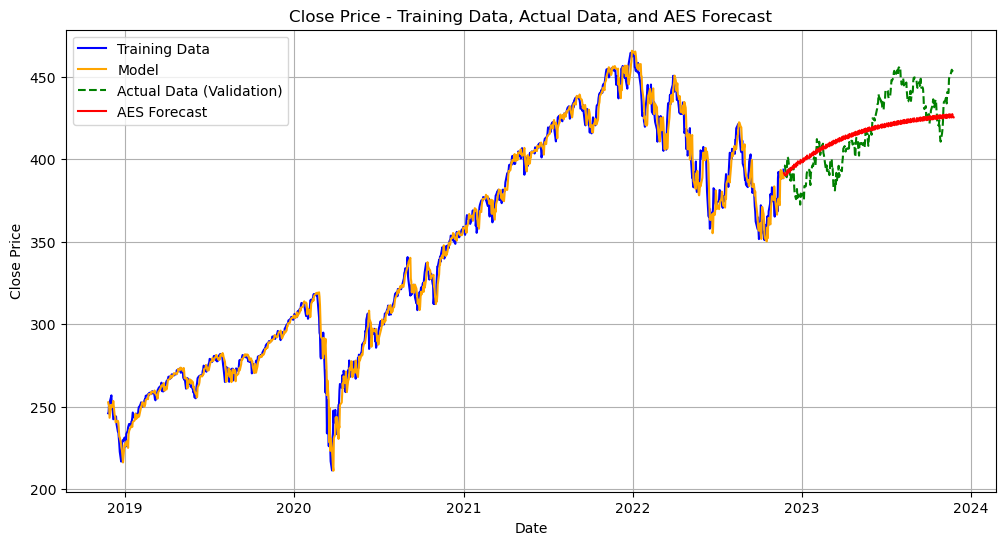

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Replicate the above, but with seasonal_periods=2 for lower AIC and BIC

In [38]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 2, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3565.9647107817514
BIC = 3600.3608722363692
Time Series Evaluation Metrics
MSE = 347.8813139307829
MAE = 14.684659019887022
RMSE = 18.65157671433659
MAPE = 0.03423066096818789
r2 = 0.33429153818406576

None


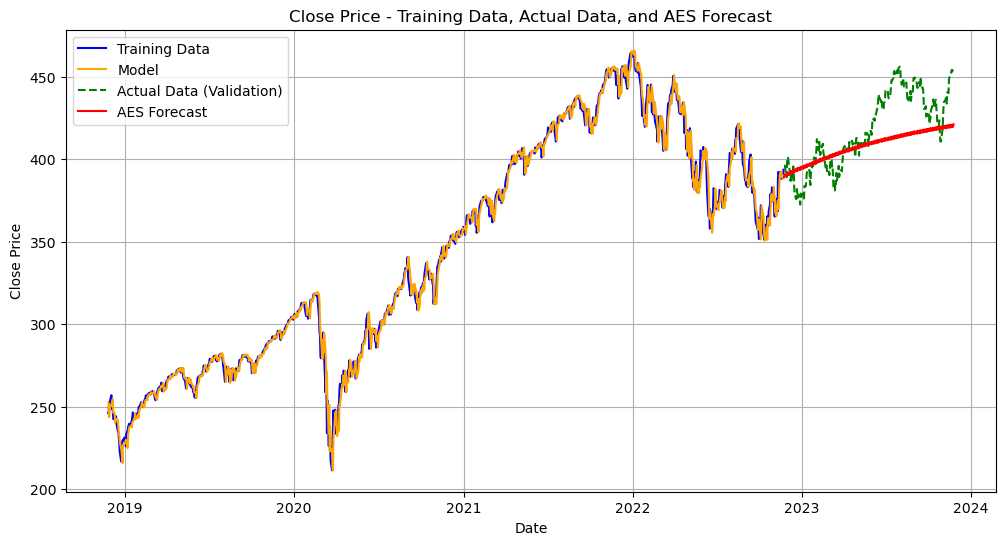

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

In [40]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average
# auto_arima_model = auto_arima(close_train, d=2, seasonal=True, stepwise=True, trace=True)
# auto_arima_model.summary()
# arima_pred = auto_arima_model.predict(n_periods=len(close_valid))
close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,0)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))

# arima_eval_metrics = ts_eval_metrics(close_valid, arima_pred)
# print(arima_eval_metrics)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1458
Model:                ARIMA(14, 1, 0)   Log Likelihood               -2939.926
Date:                Sun, 26 Nov 2023   AIC                           5909.851
Time:                        17:56:30   BIC                           5989.114
Sample:                    11-26-2018   HQIC                          5939.422
                         - 11-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1354      0.032     -4.297      0.000      -0.197      -0.074
ar.L2         -0.1104      0.031     -3.524      0.000      -0.172      -0.049
ar.L3          0.2001      0.033      6.033      0.0

In [41]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

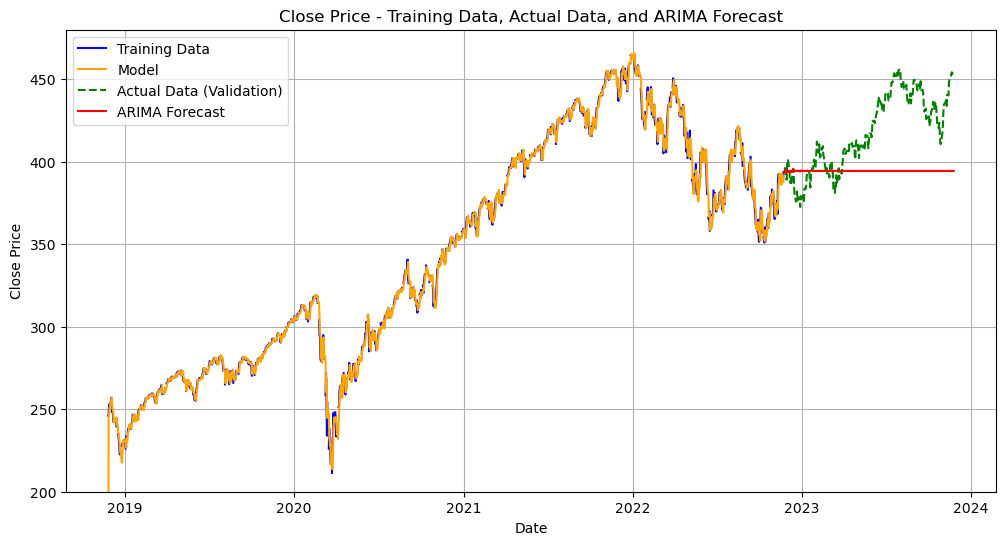

In [42]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression Model on SPY

### Add fields on open-close difference

In [43]:
hist = aapl.history(period = '1y')
# # hist = hist.diff()
# hist = hist.diff(periods=15)
# hist = hist.shift(3)
# hist = hist.dropna()
# hist['open_close'] = hist['Close'] - hist['Open']
# hist['positive'] = np.where(hist['open_close'] >= 0, 1, 0)
# hist['high_low'] = hist['High'] - hist['Low']

# X = hist.drop(['positive'], axis =1)
# y = hist['positive']

# Add columns
hist['open_close'] = hist['Close'] - hist['Open']
hist['positive'] = np.where(hist['open_close'] > 0, 1, 0)
hist['high_low'] = hist['High'] - hist['Low']
hist = hist.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1) # Clean out sparse columns
hist.head()

,Open,High,Low,Close,Volume,open_close,positive,high_low
Date,,,,,,,,
2022-11-25 00:00:00-05:00,395.602323,396.665602,395.316839,396.094574,30545400,0.492251,1,1.348763
2022-11-28 00:00:00-05:00,392.904787,394.598131,388.986459,389.774078,67881600,-3.130708,0,5.611672
2022-11-29 00:00:00-05:00,389.911913,391.142541,387.204534,389.104645,52310000,-0.807269,0,3.938007
2022-11-30 00:00:00-05:00,389.360585,401.361664,387.381757,401.361664,144566700,12.001079,1,13.979907
2022-12-01 00:00:00-05:00,402.434756,403.645704,398.477070,401.066315,76398200,-1.368442,0,5.168634


In [48]:
hist_lag = hist.copy()

lag = 3

hist_lag = hist_lag.diff(periods=lag)
#for lag in range(1, 6):
#    globals()[f'hist_lag_{lag}'] = hist_lag.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_lag[lag_col_name] = hist_lag[col].shift(i)

hist_lag = hist_lag.dropna()
#hist_lag_1 = hist_lag_1.dropna() # Remove missing values due to lags out of range
#hist_lag_2 = hist_lag_2.dropna()
#hist_lag_3 = hist_lag_3.dropna()
#hist_lag_4 = hist_lag_4.dropna()
#hist_lag_5 = hist_lag_5.dropna()

In [49]:
pd.set_option('display.max_columns', 70)
display(hist_lag.head())
#display(hist_lag_1.head())
#display(hist_lag_2.head())
#display(hist_lag_3.head())

,Open,High,Low,Close,Volume,open_close,positive,high_low,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,open_close_lag1,positive_lag1,high_low_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2,Volume_lag2,open_close_lag2,positive_lag2,high_low_lag2,Open_lag1_lag2,High_lag1_lag2,Low_lag1_lag2,Close_lag1_lag2,Volume_lag1_lag2,open_close_lag1_lag2,positive_lag1_lag2,high_low_lag1_lag2,Open_lag3,High_lag3,Low_lag3,Close_lag3,Volume_lag3,open_close_lag3,positive_lag3,high_low_lag3,Open_lag1_lag3,High_lag1_lag3,Low_lag1_lag3,Close_lag1_lag3,Volume_lag1_lag3,open_close_lag1_lag3,positive_lag1_lag3,high_low_lag1_lag3,Open_lag2_lag3,High_lag2_lag3,Low_lag2_lag3,Close_lag2_lag3,Volume_lag2_lag3,open_close_lag2_lag3,positive_lag2_lag3,high_low_lag2_lag3,Open_lag1_lag2_lag3,High_lag1_lag2_lag3,Low_lag1_lag2_lag3,Close_lag1_lag2_lag3,Volume_lag1_lag2_lag3,open_close_lag1_lag2_lag3,positive_lag1_lag2_lag3,high_low_lag1_lag2_lag3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-08 00:00:00-05:00,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.205047,-9.854852,-12.906783,-13.339996,1574000.0,-4.134950,0.0,3.051932,8.328892,-2.707395,4.617301,-7.964630,-67276900.0,-16.293522,-1.0,-7.324696,8.328892,-2.707395,4.617301,-7.964630,-67276900.0,-16.293522,-1.0,-7.324696,6.103942,10.396356,8.703041,11.498993,33032700.0,5.395051,1.0,1.693314,9.529970,9.047574,9.490611,11.292236,8516600.0,1.762266,0.0,-0.443038,-6.241738,4.696062,-7.935082,5.267090,114021300.0,11.508828,0.0,12.631144
2022-12-09 00:00:00-05:00,-4.410588,-2.333274,1.486568,-0.541473,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.205047,-9.854852,-12.906783,-13.339996,1574000.0,-4.134950,0.0,3.051932,-9.205047,-9.854852,-12.906783,-13.339996,1574000.0,-4.134950,0.0,3.051932,8.328892,-2.707395,4.617301,-7.964630,-67276900.0,-16.293522,-1.0,-7.324696,6.103942,10.396356,8.703041,11.498993,33032700.0,5.395051,1.0,1.693314,9.529970,9.047574,9.490611,11.292236,8516600.0,1.762266,0.0,-0.443038
2022-12-12 00:00:00-05:00,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410588,-2.333274,1.486568,-0.541473,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.205047,-9.854852,-12.906783,-13.339996,1574000.0,-4.134950,0.0,3.051932,8.328892,-2.707395,4.617301,-7.964630,-67276900.0,-16.293522,-1.0,-7.324696,6.103942,10.396356,8.703041,11.498993,33032700.0,5.395051,1.0,1.693314
2022-12-13 00:00:00-05:00,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410588,-2.333274,1.486568,-0.541473,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.205047,-9.854852,-12.906783,-13.339996,1574000.0,-4.134950,0.0,3.051932,8.328892,-2.707395,4.617301,-7.964630,-67276900.0,-16.293522,-1.0,-7.324696
2022-12-14 00:00:00-05:00,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410588,-2.333274,1.486568,-0.541473,3475500.0,3.869115,0.0,-3.819842,-4.410588,-2.333274,1.486568,-0.541473,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,

              precision    recall  f1-score   support

           0       0.45      0.64      0.53        14
           1       0.77      0.61      0.68        28

    accuracy                           0.62        42
   macro avg       0.61      0.62      0.60        42
weighted avg       0.67      0.62      0.63        42



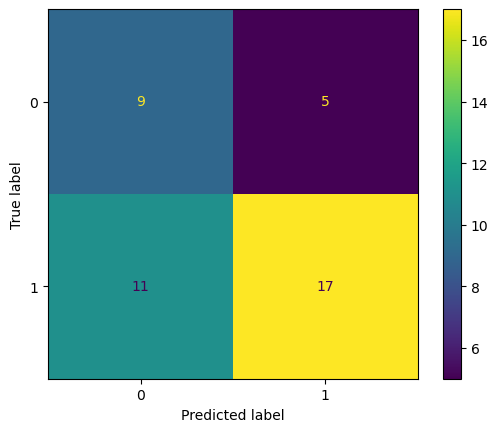

In [50]:
## Change n to lag the data
#for n in range(1, 6):  

# Data partition
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_lag.drop(['positive'], axis=1)
y = y.reindex(X.index)

end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]


# Model and fitting
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

# Model Performance  
logreg_pred = logreg_model.predict(X_valid) 
logreg_pred = pd.Series(logreg_pred, index=X_valid.index)
y_valid = y_valid.reindex(logreg_pred.index)
cm = confusion_matrix(y_valid, logreg_pred, labels=logreg_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
cmd.plot()
print(classification_report(y_valid, logreg_pred))

Lag = 1
              precision    recall  f1-score   support

           0       0.45      0.64      0.53        14
           1       0.77      0.61      0.68        28

    accuracy                           0.62        42
   macro avg       0.61      0.62      0.60        42
weighted avg       0.67      0.62      0.63        42



Lag = 2
              precision    recall  f1-score   support

           0       0.45      0.64      0.53        14
           1       0.77      0.61      0.68        28

    accuracy                           0.62        42
   macro avg       0.61      0.62      0.60        42
weighted avg       0.67      0.62      0.63        42



Lag = 3
              precision    recall  f1-score   support

           0       0.45      0.64      0.53        14
           1       0.77      0.61      0.68        28

    accuracy                           0.62        42
   macro avg       0.61      0.62      0.60        42
weighted avg       0.67      0.62      0.63   

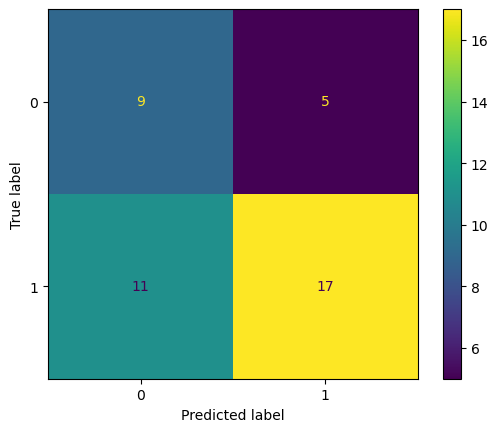

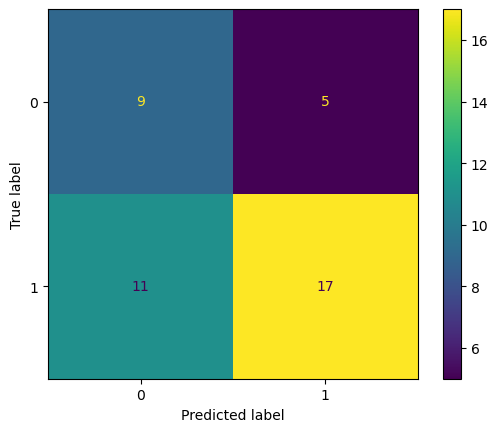

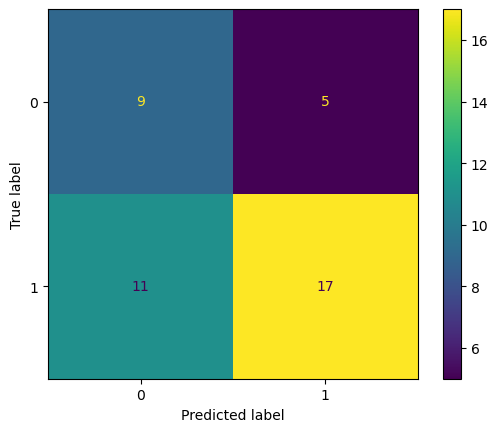

In [51]:
orders = [1,2,3] # hard-coded
log_fitted_model_dict = {}
logreg_pred_dict = {}
# Fit the models and instantiate each model individually
for i, order in enumerate(orders):
    logreg_model = LogisticRegression()
    logreg_model = logreg_model.fit(X_train,y_train)
    log_fitted_model_dict[order] = logreg_model
for order in orders:
    logreg_pred_dict[order] = log_fitted_model_dict[order].predict(X_valid) 
    logreg_pred_dict[order] = pd.Series(logreg_pred_dict[order], index=X_valid.index)
    cm = confusion_matrix(y_valid, logreg_pred_dict[order], labels=logreg_model.classes_)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
    print('Lag = %s' %(order))
    cmd.plot()
    print(classification_report(y_valid, logreg_pred_dict[order]))
    print('\n')

## Amazon  - Gabi in progress

In [52]:
# Download market data for Amazon: 

amzn = yf.Ticker("AMZN")
amzn.history_metadata

{'currency': 'USD',
 'symbol': 'AMZN',
 'exchangeName': 'NMS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 863703000,
 'regularMarketTime': 1700848801,
 'gmtoffset': -18000,
 'timezone': 'EST',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 146.74,
 'chartPreviousClose': 145.18,
 'previousClose': 146.71,
 'scale': 3,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EST',
   'start': 1700816400,
   'end': 1700836200,
   'gmtoffset': -18000},
  'regular': {'timezone': 'EST',
   'start': 1700836200,
   'end': 1700848800,
   'gmtoffset': -18000},
  'post': {'timezone': 'EST',
   'start': 1700848800,
   'end': 1700874000,
   'gmtoffset': -18000}},
 'tradingPeriods':                                           pre_start                   pre_end  \
 Date                                                                            
 2023-11-20 00:00:00-05:00 2023-11-17 04:00:00-05:00 2023-11-17 09:30:00-05:00   
 2023-11-21 00:00:00-05:00 2023-11-20 04:00:0

In [53]:
# Import Amazon stock dataset: 

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-11-26 00:00:00-05:00,76.949997,79.240501,76.210999,79.066498,125154000,0.0,0.0
2018-11-27 00:00:00-05:00,78.799500,79.882500,77.900497,79.070999,115664000,0.0,0.0
2018-11-28 00:00:00-05:00,80.695999,84.072502,80.060997,83.887497,169174000,0.0,0.0
2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.0,0.0
2018-11-30 00:00:00-05:00,83.974998,84.800003,83.324997,84.508499,115236000,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-11-17 00:00:00-05:00,142.660004,145.229996,142.539993,145.179993,49636700,0.0,0.0
2023-11-20 00:00:00-05:00,145.130005,146.630005,144.729996,146.130005,41951200,0.0,0.0
2023-11-21 00:00:00-05:00,143.910004,144.050003,141.500000,143.899994,71226000,0.0,0.0
2023-11-22 00:00:00-05:00,144.570007,147.740005,144.570007,146.710007,45669100,0.0,0.0
2023-11-24 00:00:00-05:00,146.699997,147.199997,145.320007,146.740005,22378400,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.000000
mean,126.341665,127.904266,124.669430,126.304739,7.785696e+07,0.0,0.015898
std,31.855211,32.138692,31.482601,31.766798,3.534019e+07,0.0,0.563884
min,67.300003,69.801498,65.349998,67.197998,1.762600e+07,0.0,0.000000
25%,94.631124,95.725754,93.500000,94.723627,5.428785e+07,0.0,0.000000
50%,124.945000,126.540001,123.276752,124.863503,6.707655e+07,0.0,0.000000
75%,158.346878,159.930752,156.224998,158.093746,9.219150e+07,0.0,0.000000
max,187.199997,188.654007,184.839493,186.570496,3.113460e+08,0.0,20.000000


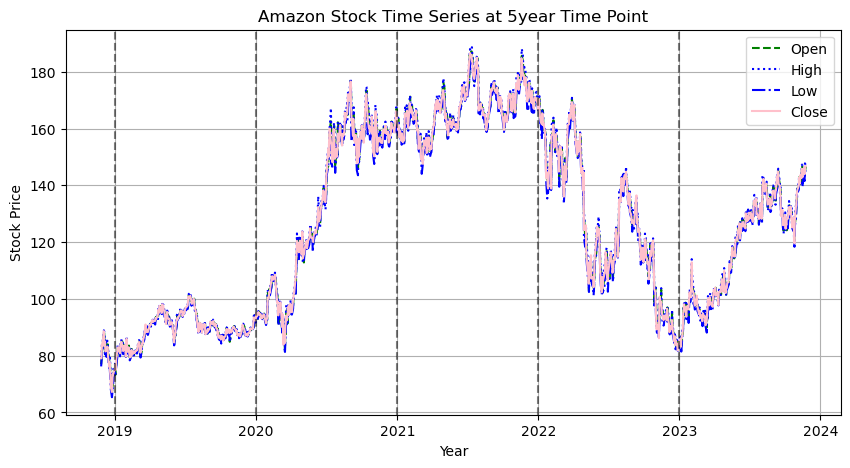

In [54]:
# Plot initial Amazon stock time series at 5y time point: 

plt.figure(figsize=(10, 5))
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='blue', linestyle='dashdot')
plt.plot(amzn_df['Close'], label='Close', color='pink')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

    
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Partition train and validation datasets: 

train = amzn_df.loc['2018-11-09':'2022-12-01']
train = train['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.loc['2022-12-02':'2023-11-08']

In [56]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

ADF Statistic: -1.544461
p-value: 0.511414
Critical Values:
{'1%': -3.434821532444398, '5%': -2.863514886524506, '10%': -2.5678214111987328}
Time series is not stationary


### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [57]:
# Fit close stock price dataset to STL: 

stl = STL(amzn_train, period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

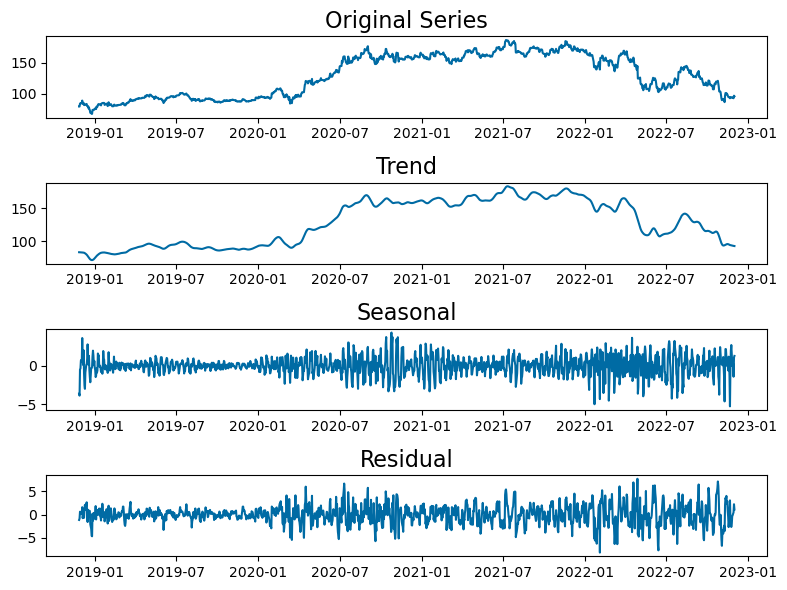

In [58]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_train)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt-Winters Smoothing

In [59]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()

amzn_smo_fore = amzn_train.copy()
amzn_smo_fore['Forecast'] = result_hw.fittedvalues
amzn_smo_fore = pd.to_numeric(amzn_smo_fore, errors='coerce')
amzn_smo_fore.dropna(inplace=True)

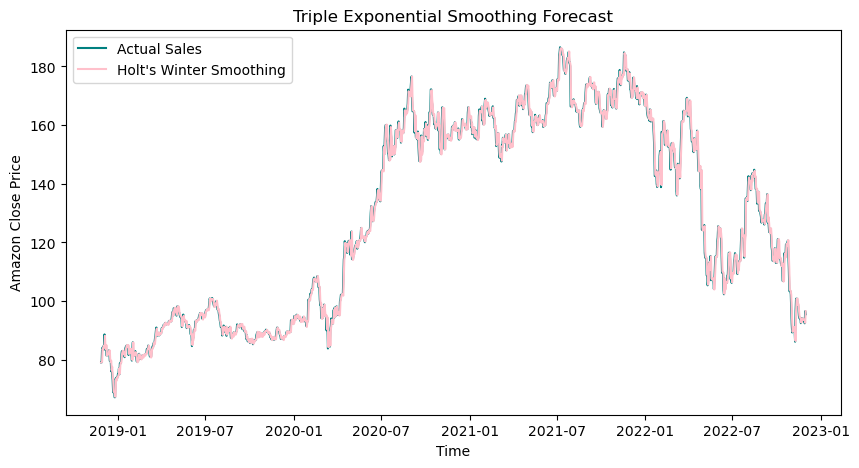

In [60]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 5))
plt.plot(amzn_smo_fore, label='Actual Sales', color = 'Teal', marker='')
plt.plot(result_hw.fittedvalues, label="Holt's Winter Smoothing", color = 'pink')
plt.xlabel('Time')
plt.ylabel('Amazon Close Price')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Anomaly Detection

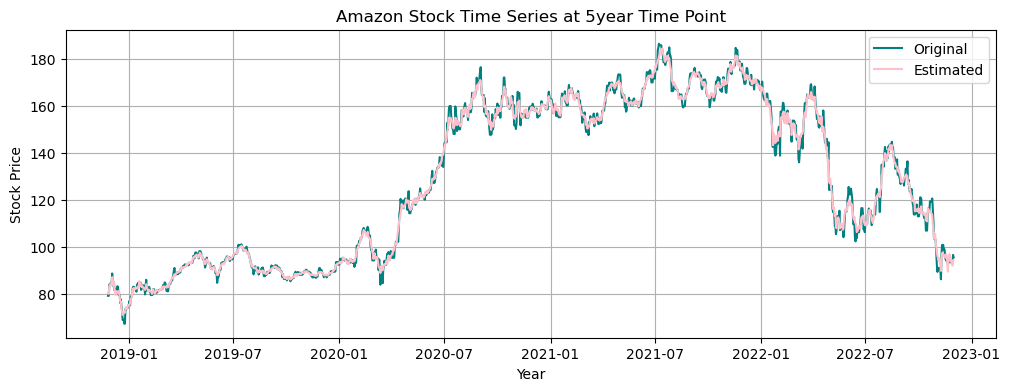

In [61]:
# Plot original Amazon Close time series vs Forecasted time series: 

estimated = trend + seasonal # from STL
plt.figure(figsize=(12,4))
plt.plot(amzn_train, label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

(17775.0, 19358.0)

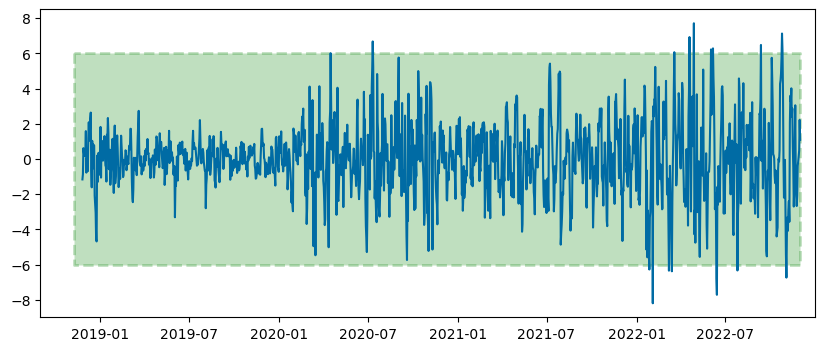

In [63]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,9), datetime(2022,12,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2023,1,1))

In [64]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_train[(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

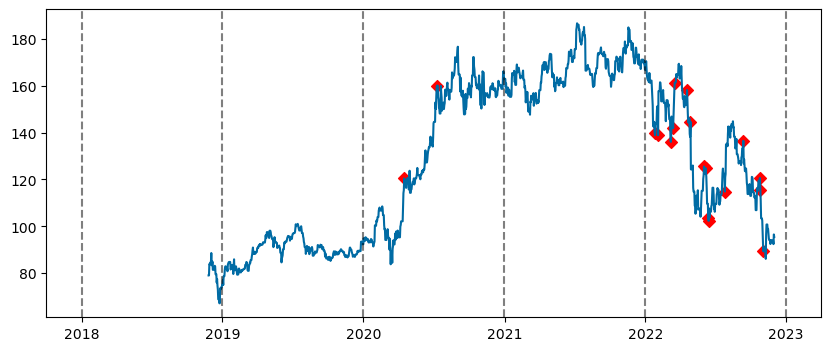

In [65]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_train)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')
#plt.xlabel('Year')
#plt.ylabel('Closing Price')

In [66]:
# Anomalies identified outside 3std dev of residuals: 

anomalies.head()

,Close
Date,
2020-04-16 00:00:00-04:00,120.409500
2020-07-11 00:00:00-04:00,160.000000
2022-01-27 00:00:00-05:00,139.637497
2022-02-03 00:00:00-05:00,138.845505
2022-03-08 00:00:00-05:00,136.014496


### Transforming Time Series to Stationary

Text(0, 0.5, 'Amazon Stock Closing Price \n(First Diff.)')

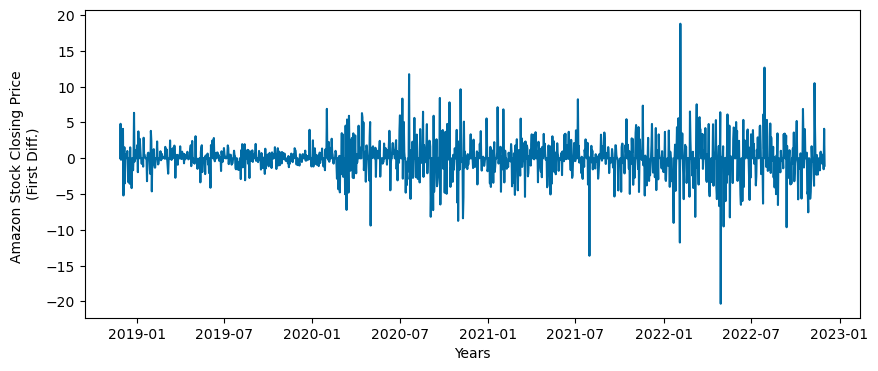

In [67]:
# Removing trend by applying the first Difference: 

diff_ts = amzn_train.diff().dropna()

# Plot first difference: 

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [68]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

ADF Statistic: -40.112198
p-value: 0.000000
Critical Values:
{'1%': -3.434821532444398, '5%': -2.863514886524506, '10%': -2.5678214111987328}
Time series is stationary


### Selecting a Model

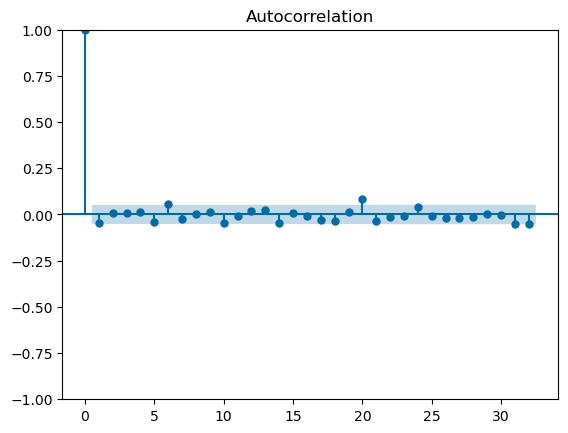

None

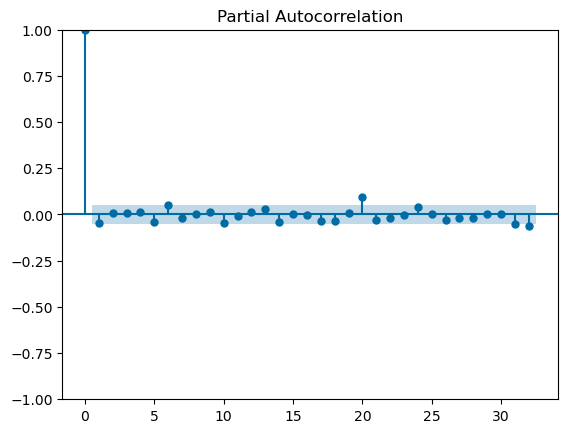

None

In [69]:
# ACF suggest MA Lag 1 

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria: 

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood 
>
>($k$) = a number of parameters 
>
>($n$) = a number of samples used for fitting


In [70]:
# Auto ARIMA Model: 
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

auto_arima_model = auto_arima(diff_ts, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

val_close = valid['Close'].asfreq('D')
arima_pred = auto_arima_model.predict(n_periods=len(val_close))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7848.375, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7374.524, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7846.375, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7188.300, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7088.085, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=7049.600, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=6979.299, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=6977.300, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=7047.601, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.22 s

In [71]:
# ARIMA Model and Forecast at ARIMA(5,1,0): 

arima_m = sm.tsa.ARIMA(diff_ts, order=(5,1,0)).fit() 
print(arima_m.summary())

arima_pred = arima_m.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1466
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3482.650
Date:                Sun, 26 Nov 2023   AIC                           6977.300
Time:                        17:59:31   BIC                           7009.038
Sample:                    11-27-2018   HQIC                          6989.137
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8790      0.018    -49.635      0.000      -0.914      -0.844
ar.L2         -0.7057      0.025    -28.784      0.000      -0.754      -0.658
ar.L3         -0.5279      0.029    -18.135      0.0

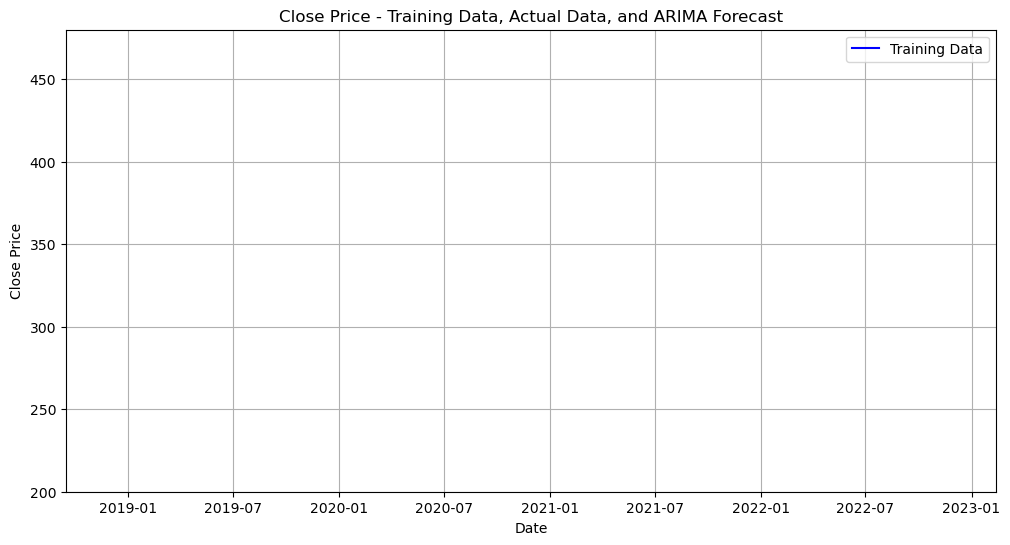

In [72]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')

plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(diff_ts, label='Training Data', color='blue')
#plt.plot(arima_m.fittedvalues, label="Model", color = 'orange') 
#plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
#plt.plot(val_close.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

###### Code References: 
    
 https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb   
    